# Making a Minecraft Tourist

In this assignment you will be making a neural network that can do image captioning.  This network will take in an image and produce a string of text describing what is found in the image.  To do this you will be constructing a relatively complicated neural network that will:

1. Use Convolutional Neural Networks (CNNs) to capture features from the images and condense it down to a vector of numbers that
2. a LSTM will use as its input, generating the caption in an auto-regressive manner

At the end of this assignment, you should understand:

1. How to construct your own custom Torch module (instead of using Sequential as you did last time)
2. How to combine multiple modules into one network
3. How to create a CNN
4. How to create an auto-regressive LSTM

First off, we have our import statements

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import pickle
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

Now we need to set up our dataset.  The data has been pickled for you (pickle is a Python specific serialization that works more seemlessly than something like XML or JSON).  

In [2]:
import scipy.misc

data = pickle.load(open('MinecraftCaption.pkl','rb'))
vocab = data[0]
vocab2index = data[1]
index2vocab = data[2]
images = data[3]

images = [np.array(scipy.misc.imresize(image,0.25)/255.,dtype='float32') for image in images]
captions = data[4]

c:\users\kenny\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


The pickle contains a tuple of:

vocabulary -- a set consisting of all of the words found in the caption dataset

vocabulary to index -- a dictionary where the keys are words and the values are the associated indices for a One-Hot encoding

index to vocabulary -- Vice versa of the previous

images -- The images (as numpy tensors) that make up the dataset

captions -- The sentences (as a list of list of words) that make up the caption portion of the dataset


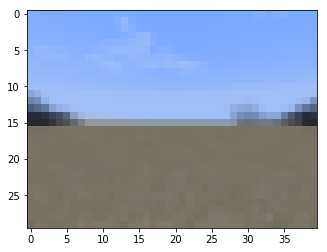

I'm in the desert and see mountains in the distance


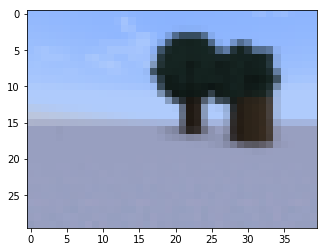

I'm standing in a snowy field and see some trees


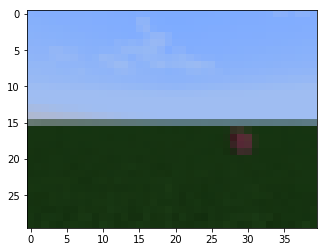

I'm in a grassy field and see a pig


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0])
plt.show()

print(' '.join(captions[0]))


plt.imshow(images[1])
plt.show()

print(' '.join(captions[1]))


plt.imshow(images[2])
plt.show()

print(' '.join(captions[2]))


First, we need to set up our captions for consumption by the Neural Network.  To do this, we will need to take our list of lists of words and turn it into a Tensor with dimensions

data point x sequence step

Now, you might be thinking, don't we need this to be a One-Hot encoding?  And the answer is "Yes", but we will be using a special embedding layer as the input to our LSTM that goes from One-Hot index to a vector of trainable weights.  In our case, this won't make much difference, but in datasets that have to cover an entire language it means we can have a Tensor filled with indices that get reduced down to a smaller dimensional space (say from 1,000,000 words down to a 256 dimensional vector) instead of keeping around a sparesely filled Tensor (that would have to have a million mostly unused entries).

For the sake of being able to batch (instead of running one at a time) we will need to pad all of our sequences to the length of the largest sequence found in our dataset.

1. Loop through the captions and construct a list consisting of the lengths (plus one -- we'll get to this in a second) of the captions

2. Find the maximum of those lengths

3. Go through all of the captions and construct the one-hot encoding

The easiest way to construct the one-hot encoding is to use a list comprehension for each line in the caption

`one_hot = [expression_that_turns_a_word_into_an_index(word) for word in caption]`

(Think about what we have that can go from word to index)

However, this isn't quite all we need to do.  As it is, we have captions with different lengths, and PyTorch doesn't allow for jagged Tensors, so we will need to pad our Tensors (this step wouldn't be required if we were doing non-batched SGD, but we will be batching so it is required).  Even if we didn't want to pad our sequences, we would most likely want to use a special "end of sequence" word to indicate when to stop the auto-regressive generation (here we use `'<END>'`.

So instead of the above we should do:


`one_hot = [expression_that_turns_a_word_into_an_index(word) for word in caption] + [expression_that_turns_a_word_into_an_index('<END>')] * number_of_tokens_to_add_to_get_to_max_len`


and we'll do that for every caption found in `captions`


(Think about how many tokens you need to add to a sequence to reach the length of the maximum sequence.  If the left list is the same size as the maximum sequence how many tokens do you add?  If it is of size 0, how many tokens do you add?)

We then need to turn the list of lists of caption indices into a tensor --

`caption_ids = torch.tensor(caption_ids, dtype=torch.long)`





In [4]:
captions = data[4]

captionLengths = [] #to hold the list of caption lengths
count = 0

for row in captions:
    for column in row:
        count += len(column)
    captionLengths.append(count+1)
    count = 0

#TODO calculate the maximum length + 1 for the captions
max_len = 0

for row in captionLengths:
    if (row > max_len):
        max_len = row

#TODO turn the captions into a list of lists of integer indices indicating the one-hot encoding 
#they should all be padded with '<END>' at the end up to the maximum length + 1 calculated above

caption_ids = None

for i in range(len(captions)):
    one_hot = [vocab2index[column] for column in captions[i]] + [vocab2index['<END>']] * (max_len - captionLengths[i])

caption_ids = one_hot
caption_ids = torch.tensor(caption_ids, dtype=torch.long)

One final thing, to use the padding and batching, we would need to sort our inputs so that they are in descending order by length. 

I've actually found better results by randomly shuffling the data, so we'll be doing that, however we do need our array of lengths to be set to the maximum length, or Torch will get mad at us for having data in non-descending order.

In [5]:
lengths = captionLengths
lengths = [max_len]*len(lengths) #max_len is 76

print(lengths)

[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76,

As of now `images` is a list of numpy arrays (height x width x color channels) and we want to turn it into a 4-dimensional PyTorch Tensor with dimensions:

data point x color x height x width

First you will want to turn the list of images into a numpy Tensor with `np.array()`
This will have dimensions:

data point x height x width x color

You will then want to convert this into a PyTorch tensor via `torch.from_numpy()`

which will still have the dimensions:

data point x height x width x color

You will then want to use `.permute((dim1, dim2, dim3, dim4))` on the PyTorch Tensor which will rearrange the order of the dimensions.

e.g. If you did `imageTensor.permute((3,2,1,0))` on a tensor with the dimensions 

data point x height x width x color

it would produce a tensor with dimensions

color x height x width x data point

i.e. the 4th dimension is now first, the 3rd is now 2nd, the 2nd is now third and the first is last (0 indexed of course) 



In [6]:
#TODO turn the above image array into a Tensor

imageTensorNP = np.array(images) #list of numpy images to numpy tensor

imageTensor = torch.from_numpy(imageTensorNP) #numpy tensor to PyTorch tensor

#batch_size, channels, height, width
imageTensor = imageTensor.permute((0,3,1,2)) #pemute the PyTorch to be (data points, channels, height, width) instead of (data points, height, width, channels)
print(imageTensor.shape)

torch.Size([1000, 3, 30, 40])


Ok, we've set our data up, now we need to construct our networks.  We will be constructing two networks here.  

To do this we will be crafting custom Modules.  A Module in PyTorch can be thought of as a custom layer or set of layers.  Here we will be using them to contain a number of different layers.  The only two things we need in a Module are:

`__init__` -- The constructor

`forward` -- What the module does in the forward pass

PyTorch is really nice and uses a technique known as **autograd** that automatically computes the derivatives and makes the backwards pass on its own (assuming we are using functions that it knows how to differentiate).  We can even use arbitrary mathematics in our forward pass (assuming PyTorch knows how to differentiate the functions we are using).




First let's make the Convolutional Encoder:
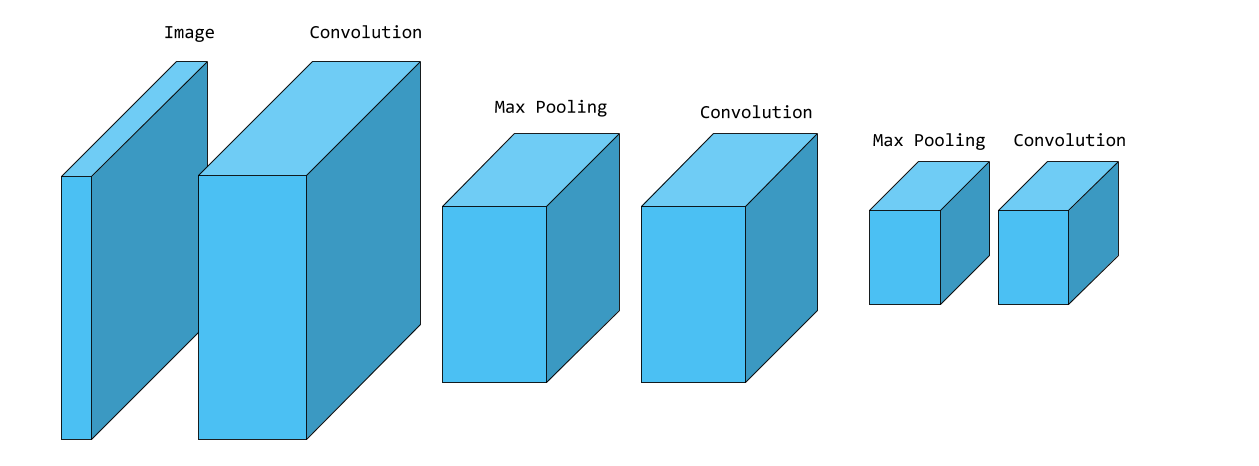

Our Encoder will take in a number of parameters:

`channels` the number of filters we wish to use in our convolutions

`embedding_size` the size of the vector that we will be encoding into

For the sake of this model, we will be constructing an encoder with 3 convolutional layers.

In the `__init__` method is where you will want to construct your layers -- for each layer you should construct:

`torch.nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)`

The convolutional layer -- 
I suggest using `kernel_size=3, stride=1, padding=1` for now, but later you can experiment with this.


`torch.nn.BatchNorm2d(channels)` -- a Batch Normalization layer applied after the convolution.  Batch normalization is a regularization technique for Convolutional Neural Networks that scales the output of the convolution to a better range

`torch.nn.MaxPool2d(kernel_size, stride, padding)` -- the Max Pooling layer -- I suggest using kernel_size=2, stride=2, padding=0

After constructing a `Conv2d, BatchNorm2d,` and `MaxPool2d` for each of the 3 layers, we will need to construct a `Linear` layer to go from the output of the final max pooling to the size of our embedding.

Now, at this point, it's a little tricky to figure out the dimensionality of the final max pooling (you can calculate it, knowing the # of channels, the kernel sizes, the strides, and the padding, but that's a bit tricky) -- put a placeholder number (say 999) in for the input_dimension for now.  This will eventually give you the error when you try to train your model below:

"...size mismatch, m1: [1 x ???], m2: [999 x 512]"

You will then need to replace the 999 with what is found in ??? -- note, that will differ based on the number of channels, so your `Linear` layer should be something like `Linear(channels*CONSTANT, embedding_size)` where `channels*CONSTANT` equals ???


### Things to think about for the constructor:

1. How many input channels does the first Convolutional layer have?  

2. How many input channels does the second have?

3. How many output channels does the first CNN layer have?

4. How many output channels does the second have?


Next, we need to use all of our constructed layers in our forward pass.

Assuming you've named your layers as:

`self.conv{i} self.bn{i} self.pool{i}`

e.g. the first layer would be:

`self.conv1, self.bn1, self.pool1`

You can apply them a la:

`#output after first convolution`

`x = self.pool1(F.relu(self.bn1(self.conv1(x))))`

After doing this for all of the layers, we will need to flatten our learned features.  The easiest way to do this is via `.reshape()`.

`.reshape()` takes a tensor and turns it into a Tensor with the specified dimensions:

e.g.

`twoByThree = tensor.reshape(2,3)` would take any tensor that had 6 elements and put it into one that was 2 x 3

a nice thing that PyTorch lets us do is use `-1` as a filler that will be figured out from the other dimensions, so since we want to go to from a 'data points x channels x ??unknown reduced width?? x ??unknown reduced height??' Tensor to a 'data points x (channels * ??unknown reduced width?? * ??unknown reduced height??)' we can just do:

`x = x.reshape(x.size(0), -1)`

Apply the final `Linear` layer and a `relu` activation and return the output of all of this

In [25]:
class EncoderCNN(nn.Module):
    def __init__(self, channels, embedding_size):
        super(EncoderCNN, self).__init__()
        
        #TODO set up you Encoder CNN
        self.channels = channels
        #Input channels = 3
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(channels)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(channels)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(channels)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.embed = torch.nn.Linear(in_features=999, out_features=embedding_size)
        
    def forward(self, x):
        #TODO apply the 3 convolutional layers (convolution, batch norm, relu, pool)
        
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        #TODO reshape the data
        
        x = x.reshape(x.size(0), -1)
        
        #TODO embed the output and apply a ReLU activation
        
        x = F.relu(self.embed(x)) #relu
        
        return x

Now we need to construct our LSTM based Decoder.

Our Decoder takes in a few more parameters than our Encoder did.

`embedding_size` -- the size of the embedding, this should match the embedding_size above

`hidden_size` -- the number of hidden nodes in each LSTM layer

`vocab_size` -- the number of unique words in our vocabulary

`num_layers` -- the number of LSTM layers to use


As mentioned above, we will be using an `Embedding` layer to go from One-Hot indices into a embedded space (of the same dimensionality as our EncoderCNN embeds into, of course).

So, we need to construct a `nn.Embedding(vocab_size, embedding_size)` that will take our inputs (currently integers indicating the one-hot encoding index) and embed them into a different dimensionality (our provided embedding size).


Then we construct the LSTM layers -- unlike above, the LSTM module in PyTorch allows us to construct all of our layers in 1 module `nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)`  -- since we are doing batching, we need to tell our LSTM that it can batch across our first dimension.

Finally, after the LSTMs we will need to do a Softmax regression going to the size of our vocab (since we are predicting words from our vocab) -- so we need a `nn.Linear(hidden_size, vocab_size)`


In the forward pass, we need to:

1. Embed the captions
2. Concatenate the EncoderCNN features to the embedded captions
3. Pack the concatenated sequence so that we can do batching
4. Call the LSTM layer on the packed sequence
5. Apply the linear layer -- in a move that will maybe seem a bit confusing here, **don't** apply a Softmax activation


2. and 3. are a little unintuitive, so they are taken care of for you 


the output of calling the LSTM on the packed sequence are:

`output, (h_n, c_n) = self.lstm(????)` 

where 

`output` is "tensor containing the output features (h_t) from the last layer of the LSTM, for each t." If we only cared about the last output feature, we could use (h_n and c_n), but since we are doing a decoding of all of our steps, we instead will use the output (again, since we are using the packed_padded_sequence, we need to do things a little differently, and will only be using `output[0]`) 

Apply the `Linear` activation to `output[0]` and return that.

In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        
        #TODO -- set up the parameters for the Decoder LSTM
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        #TODO 1. Embed
        embeddings = None
        
        #2. Concatenate the encoded features
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        #3. Pack the padded sequence
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        
        #TODO 4. Apply the linear output
        
        return outputs
        
    
 
    def sample(self, features, states=None):
        #This does a greedy decoding ( the outputs.max line)
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          
            outputs = self.linear(hiddens.squeeze(1))            
            _, predicted = outputs.max(1)                        
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       
            inputs = inputs.unsqueeze(1)                         
        sampled_ids = torch.stack(sampled_ids, 1)                
        return sampled_ids

Now that we have defined our Modules, we construct them here.

In [27]:
embed_size = 512
hidden_size = 256
channels = 256
num_layers = 3

encoder = EncoderCNN(channels, embed_size)
decoder = DecoderRNN(embed_size,hidden_size, len(vocab), num_layers)

We need to set up our parameters (gotten from our modules by calling `.parameters()`) and our optimizer (I recommend the Adam (no relation) optimizer).

Earlier, we didn't apply a Softmax layer, and that's because Torch gives us a special loss function `nn.CrossEntropyLoss` that combines a standard Softmax activation and Negative Log Cross Entropy loss into one (running a bit faster and resulting in better numerical stability).

In [ ]:
learning_rate =0.0001
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters()) 
optimizer = torch.optim.Adam(params, lr=learning_rate)

Now it is time to train our model.  Train the model until it seems like it has converged -- Loss around 0.1-0.2 is what I found to be acceptable.

In [ ]:
import random
batch_size = 4
num_epochs = 15
log_step = 10
batches = list(range(0,imageTensor.shape[0],batch_size))

for epoch in range(num_epochs):
    random.shuffle(batches)
    for bid, batch in enumerate(batches):
        batch_image = imageTensor[batch:batch+batch_size,:,:,:]
        batch_captions = caption_ids[batch:batch+batch_size,:]
        batch_lengths = lengths[batch:batch+batch_size]
        features = encoder(batch_image)
        outputs = decoder(features, batch_captions, batch_lengths)
        targets = pack_padded_sequence(batch_captions, batch_lengths, batch_first=True)[0]
            
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        if bid % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, bid,len(batches),  loss.item(), np.exp(loss.item()))) 

Now, let's see the fruits of our labor!

In [ ]:
#Change this to see how it handles different images
batch = 5


decoder.zero_grad()
batch_image = imageTensor[batch:batch+batch_size,:,:,:]
batch_captions = caption_ids[batch:batch+batch_size,:]
features = encoder(batch_image)
outputs = decoder.sample(features)

for num,caption in enumerate(outputs):
    plt.imshow(images[batch+num])
    plt.show()
    print('PREDICTED: ' + ' '.join([index2vocab[w] for w in caption.numpy() if index2vocab[w] != '<END>']))
    print('TRUTH:' + ' '.join(captions[batch+ num]))

Extra Credit:

Try to play around with the architectures and see if you can get a better result than the model that I've lead you through.

Things to consider:

Different Convolutional Architecture

Regularization 

Different dimensions/numbers of layers

Attention

Beam-Search